# Fig3: eY1H/PDI analyses

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sys

# import utils
sys.path.append("../")

from data_loading import load_annotated_TFiso1_collection, load_y1h_pdi_data
from plotting import y1h_pdi_per_tf_gene_plot, m1h_activation_per_tf_gene_plot

In [3]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [4]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [5]:
np.random.seed(2023)

## 1. load PDI data

In [6]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [7]:
def disordered_fraction_of_different_regions(gene, ref_iso_name, alt_iso_name):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)
    if not hasattr(gene[ref_iso_name], 'disorder') or not hasattr(gene[alt_iso_name], 'disorder'):
        return np.nan
    ref_iter = iter(gene[ref_iso_name].disorder)
    alt_iter = iter(gene[alt_iso_name].disorder)
    merged_disorder = []
    for pos in algn:
        if pos == 'I':
            merged_disorder.append(next(alt_iter))
        elif pos == 'D':
            merged_disorder.append(next(ref_iter))
        else:
            merged_disorder.append(next(ref_iter))
            next(alt_iter)

    return np.mean([is_disordered for pos, is_disordered in zip(algn, merged_disorder) if pos != 'M'])


disordered_fraction_of_different_regions(tfs['CREB1'], 'CREB1-2', 'CREB1-1')

1.0

In [31]:
# TODO move to isolib
def n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, domain_start, domain_end):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)

    def _coords_transform_aa_seq_to_alignment(i, alignment):
        if i > len(alignment.replace("I", "")):
            raise ValueError("position is not in isoform AA sequence")
        aa_seq_indices = [
            "" if c == "I" else len(alignment[:j].replace("I", ""))
            for j, c in enumerate(alignment)
        ]
        return aa_seq_indices.index(i)
    
    start = _coords_transform_aa_seq_to_alignment(domain_start, algn)
    end = _coords_transform_aa_seq_to_alignment(domain_end - 1, algn) + 1

    if not all(x == 'M' for x in algn[start:end]):
        return 0  # change is within the domain
    
    big_number = 9999999999999999999999999
    c_dist = big_number
    n_dist = big_number
    for i, l in enumerate(reversed(algn[:start])):
        if l != 'M':
            c_dist = i + 1
            break
    for i, l in enumerate(algn[end:]):
        if l != 'M':
            n_dist = i + 1
            break
    if c_dist == big_number and n_dist == big_number:
        raise UserWarning('problem calculating distance')
    return min([c_dist, n_dist])


def n_aa_to_all_features(self, ref_iso_name):
    results = []
    ref_iso = self[ref_iso_name]
    row = {"gene": self.name, "ref_iso": ref_iso_name}
    for aa_feature in ref_iso.aa_seq_features:
        for alt_iso_name, alt_iso in self._iso_dict.items():
            if alt_iso_name == ref_iso_name:
                continue
            row.update(
                {
                    "alt_iso": alt_iso_name,
                    "accession": aa_feature.accession,
                    "category": aa_feature.category,
                    "start_in_ref_iso": aa_feature.start,
                    "end_in_ref_iso": aa_feature.end,
                    "length": aa_feature.end - aa_feature.start,
                }
            )
            row.update({"n_aa_change_to_domain": n_aa_change_from_feature(self, ref_iso_name, alt_iso_name, aa_feature.start, aa_feature.end)})
            results.append(row.copy())
    results = pd.DataFrame(results)
    return results

In [33]:
dist = pd.concat([n_aa_to_all_features(g, g.cloned_reference_isoform.name) for g in tfs.values()])
dist['is_DBD'] = dist['accession'].isin(load_dbd_accessions())

In [46]:
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()  # TODO: why is this here?
n_pdi = (y1h.drop(columns='gene_symbol')
            .set_index('clone_acc')
            .sum(axis=1))
n_pdi.index = n_pdi.index.map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [36]:
df = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
df['is_DBD'] = df['accession'].isin(load_dbd_accessions())
df['is_DBD_flank'] = (df['accession'].str.endswith('_flank_N') |
                      df['accession'].str.endswith('_flank_C'))

In [40]:
dist

,gene,ref_iso,alt_iso,accession,category,start_in_ref_iso,end_in_ref_iso,length,n_aa_change_to_domain,is_DBD
0,ZBTB18,ZBTB18-1,ZBTB18-2,PF00651,Pfam_domain,22,130,108,14,False
1,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_4,ZF_array,373,486,113,365,True
2,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_4_flank_N,DBD_flank,358,373,15,350,False
3,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2_ZF_array_4_flank_C,DBD_flank,486,501,15,478,False
4,ZBTB18,ZBTB18-1,ZBTB18-2,DelRosso_RD_ZBTB18_1,effector_domain,211,291,80,203,False
...,...,...,...,...,...,...,...,...,...,...
22,ZFY,ZFY-1,ZFY-204,DelRosso_RD_ZFY_4,effector_domain,695,775,80,361,False
23,ZFY,ZFY-1,ZFY-207,DelRosso_RD_ZFY_4,effector_domain,695,775,80,510,False
0,HSFY1,HSFY1-1,HSFY1-2,PF00447,Pfam_domain,79,194,115,0,True
1,HSFY1,HSFY1-1,HSFY1-2,PF00447_flank_N,DBD_flank,64,79,15,93,False


In [41]:
df_new = (df.loc[df['is_DBD'], :]
        .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
        [['deletion', 'frameshift']].sum()
        .sum(axis=1) / df.loc[df['is_DBD'], :]
        .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
        ['length'].sum()).to_frame(name='dbd_fraction')

df_new['dbd_insertion_n_aa'] = (df.loc[df['is_DBD'], :]
                                  .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
                                  ['insertion']
                                  .sum())

df_new['dbd_n_aa_to_change'] = (dist.loc[dist['is_DBD'], :]
                                  .groupby(['gene', 'ref_iso', 'alt_iso'])
                                  ['n_aa_change_to_domain']
                                  .min())

In [43]:
# flank affected
df_new['dbd_flank_affected'] = (df.loc[df['is_DBD_flank'], :]
        .groupby(['gene_symbol', 'ref_iso', 'alt_iso'])
        [['deletion', 'insertion', 'frameshift']].sum()
        .sum(axis=1) > 0)
df = df_new.reset_index()
df['dbd_pct_lost'] = df['dbd_fraction'] * 100.

In [44]:
def dbd_affected_categories(pct_lost):
    if pct_lost < 0:
        raise ValueError('negative percent value')
    elif pct_lost == 0:
        return 'Full DBD in\nalternative isoform'
    elif pct_lost >= 100:
        return 'Full loss\nof DBD'
    else:
        return 'Partial loss\nof DBD'

df['dbd_affected'] = df['dbd_pct_lost'].apply(dbd_affected_categories)
df['dbd_or_flank_affected'] = df['dbd_affected']
df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
       df['dbd_flank_affected'], 'dbd_or_flank_affected'] = 'DBD flank affected'

In [45]:
isoforms = load_valid_isoform_clones()

In [48]:
# map each isoform to change in PDI vs reference
def delta_pdi(row):
    iso_acc = row['alt_iso']
    ref_acc = row['ref_iso']
    if iso_acc == ref_acc:
        return np.nan
    n_ref = n_pdi.get(ref_acc, np.nan)
    n_iso = n_pdi.get(iso_acc, np.nan)
    if n_ref == 0:
        return np.nan
    return (n_iso - n_ref) / n_ref


df['delta_pdi'] = df.apply(delta_pdi, axis=1)
df = df.dropna(subset=['delta_pdi'])

df['tf_family'] = df['gene_symbol'].map(lambda x: tfs[x].tf_family)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

if (((df['dbd_fraction'] > 0) | (df['dbd_insertion_n_aa'] > 0)) & (df['dbd_n_aa_to_change'] > 0)).any():
    raise UserWarning('something wrong with calculations')
if ((df['dbd_fraction'] == 0) & (df['dbd_insertion_n_aa'] == 0) & (df['dbd_n_aa_to_change'] == 0)).any():
    raise UserWarning('something wrong with calculations')

In [49]:
df.loc[df['dbd_insertion_n_aa'] > 0 ]

,gene_symbol,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc
72,DLX4,DLX4-1,DLX4-3,0.245614,26,0,True,24.561404,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,Homeodomain,-1.0
204,HEY1,HEY1-2,HEY1-1,0.000000,4,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.0,bHLH,-1.0
252,KLF7,KLF7-1,KLF7-4,0.000000,1,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.0,C2H2 ZF,-1.0
288,MAX,MAX-1,MAX-5,0.346154,39,0,True,34.615385,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,bHLH,-1.0
289,MAX,MAX-1,MAX-6,0.346154,39,0,True,34.615385,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,bHLH,-1.0
505,RFX4,RFX4-1,RFX4-3,0.873418,32,0,True,87.341772,Partial loss\nof DBD,Partial loss\nof DBD,-1.0,RFX,-1.0


In [51]:
# count
print(len(tfs), 'TF genes')
print(sum([len(tf.cloned_reference_isoform.aa_seq_features) > 0 for tf in tfs.values()]),
      'TF genes with at least one Pfam domain in cloned reference isoform')
print(sum([len(tf.cloned_reference_isoform.dna_binding_domains) > 0 for tf in tfs.values()]))
tfs_no_dbd = {k: v for k, v in tfs.items()
              if len(v.cloned_reference_isoform.dna_binding_domains) == 0
              and len(v.cloned_reference_isoform.aa_seq_features) > 0}

309 TF genes
301 TF genes with at least one Pfam domain in cloned reference isoform
271


In [52]:
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

In [53]:
df['dbd_or_flank_affected'].value_counts().index.values

array(['Full DBD in\nalternative isoform', 'Partial loss\nof DBD',
       'DBD flank affected', 'Full loss\nof DBD'], dtype=object)

In [54]:
df['tf_family_merged'] = df['tf_family'].map(lambda x: x if x in ['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor'] else 'other')

In [57]:
# TODO: move to data_loading.py
dis = pd.read_csv('../../data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
                  sep='\t')
n_aa = dis.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = dis.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']
for c in n_aa.columns:
    df[f'delta_{c}'] = df['ref_iso'].map(n_aa[c]) - df['alt_iso'].map(n_aa[c])
    df[f'abs_delta_{c}'] = df[f'delta_{c}'].abs()

In [58]:
df['f_disorder_delta_aa'] = df['abs_delta_n_aa_disordered'] / (df['abs_delta_n_aa_disordered'] + df['abs_delta_n_aa_ordered'])

In [59]:
df['pdi_affected'] = (df['delta_pdi'] != 0)

In [61]:
df['dbd_or_flank_affected'].value_counts()

Full DBD in\nalternative isoform    31
Partial loss\nof DBD                12
DBD flank affected                   9
Full loss\nof DBD                    6
Name: dbd_or_flank_affected, dtype: int64

In [63]:
# check for family enrichment of DBD unaffected PDI changes
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'tf_family'].value_counts()

bHLH                6
Nuclear receptor    4
Homeodomain         3
AP-2                2
SMAD                2
STAT                2
Ets                 1
bZIP                1
T-box               1
C2H2 ZF             1
Name: tf_family, dtype: int64

In [65]:
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'gene_symbol'].value_counts()

TCF4      3
PPARG     2
NFIX      2
STAT3     2
TFAP2A    2
PRRX1     1
MYF6      1
DLX4      1
RARG      1
TBX5      1
CREB1     1
MEOX1     1
MAX       1
HEY1      1
THRA      1
FLI1      1
KLF7      1
Name: gene_symbol, dtype: int64

In [67]:
# 15 aa flanks
' '.join(df.loc[(df['dbd_fraction'] == 0) &
       (df['dbd_flank_affected'] == False) &
       (df['delta_pdi'] != 0), 'gene_symbol'].unique())

'CREB1 DLX4 FLI1 HEY1 KLF7 MAX MEOX1 MYF6 NFIX PPARG PRRX1 RARG STAT3 TBX5 TCF4 TFAP2A THRA'

In [68]:
(df['dbd_pct_lost'] > 0).sum()

18

In [70]:
# full DBD in alternative isoform, fraction in disordered
df['f_disorder_difference'] = df.apply(lambda x: disordered_fraction_of_different_regions(tfs[x['gene_symbol']], x['ref_iso'], x['alt_iso']), axis=1)

In [71]:
df.dbd_or_flank_affected.value_counts()

Full DBD in\nalternative isoform    31
Partial loss\nof DBD                12
DBD flank affected                   9
Full loss\nof DBD                    6
Name: dbd_or_flank_affected, dtype: int64

In [72]:
# color map
t = df.loc[:,'f_disorder_difference'].values
norm = plt.Normalize(df.loc[:,'f_disorder_difference'].min(), df.loc[:,'f_disorder_difference'].max())
cmap = sns.color_palette("flare", as_cmap=True)
palette = {value: cmap(norm(value)) for value in t}

def re_color(row, palette):
    if pd.isnull(row['f_disorder_difference']):
        color = palette[0]
    else:
        color = palette[row['f_disorder_difference']]
    return color

df["color"] = df.apply(re_color, axis=1, palette=palette)
df.sample(5)

,gene_symbol,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,...,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,f_disorder_difference,color
563,STAT3,STAT3-1,STAT3-3,0.0,0,227,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,97.0,97.0,-6.0,6.0,103.0,103.0,0.055046,True,0.010101,"(0.92864754, 0.68116207, 0.4993754, 1.0)"
482,PRRX1,PRRX1-2,PRRX1-3,0.0,0,49,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,45.0,45.0,48.0,48.0,-3.0,3.0,0.941176,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)"
255,KLF7,KLF7-1,KLF7-7,1.0,0,0,True,100.0,Full loss\nof DBD,Full loss\nof DBD,...,215.0,215.0,121.0,121.0,94.0,94.0,0.562791,True,0.649254,"(0.61866821, 0.21416307, 0.43749868, 1.0)"
213,HMGA1,HMGA1-1,HMGA1-2,0.0,0,1,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,...,11.0,11.0,11.0,11.0,0.0,0.0,1.000000,True,1.000000,"(0.29408557, 0.13721193, 0.38442775, 1.0)"
204,HEY1,HEY1-2,HEY1-1,0.0,4,0,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,...,-4.0,4.0,-1.0,1.0,-3.0,3.0,0.250000,True,0.000000,"(0.92907237, 0.68878959, 0.50411509, 1.0)"


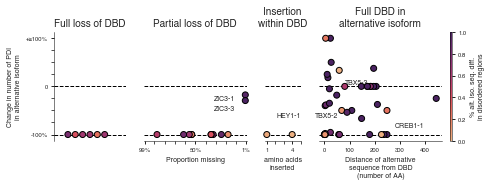

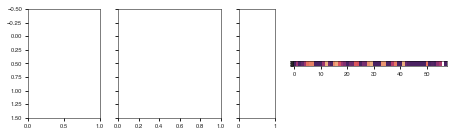

In [75]:
# try distance from DBD
# TODO
# check y variable now that we use reference isoform
# horizontal line across whole

gs_kw = dict(width_ratios=[0.7, 1, 0.35, 1.5])
fig, axs = plt.subplots(nrows=1, 
                        ncols=4,
                        sharey=True,
                        gridspec_kw=gs_kw)
fig.set_size_inches(w=7.5, h=2)
point_size = 6

axs[0].set_title('Full loss of DBD',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full loss\nof DBD',
                     ],
              ax=axs[0],
              palette=palette,
              hue='f_disorder_difference',
               linewidth=1,
               edgecolor="black",
              alpha=1,
             zorder=10)
axs[0].get_legend().remove()

axs[1].set_title('Partial loss of DBD',
fontsize=10)
axs[1].scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
               df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            c=df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False,
              zorder=10)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(100, 0)
axs[1].set_xticks([99, 50, 1])
axs[1].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
axs[1].set_xticks(range(10, 91, 10), minor=True)

# annotate zic3
axs[1].annotate("ZIC3-1", xy=(df.loc[(df["alt_iso"] == "ZIC3-1"), 'dbd_pct_lost'].values, 
                              df.loc[(df["alt_iso"] == "ZIC3-1"), 'delta_pdi_trunc'].values),
                xytext=(-10, 0), textcoords='offset points', arrowprops = dict(arrowstyle="-"),
                ha="right", va="top", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
axs[1].annotate("ZIC3-3", xy=(df.loc[(df["alt_iso"] == "ZIC3-3"), 'dbd_pct_lost'].values, 
                              df.loc[(df["alt_iso"] == "ZIC3-3"), 'delta_pdi_trunc'].values),
                xytext=(-10, -5), textcoords='offset points', arrowprops = dict(arrowstyle="-"),
                ha="right", va="top", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


axs[2].set_title('Insertion\nwithin DBD',
fontsize=10)
axs[2].scatter(df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'dbd_insertion_n_aa'].values,
               df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            c=df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False,
              zorder=10)
axs[2].set_xlabel('amino acids\ninserted')
axs[2].set_xticks([1, 4])
axs[2].set_xticks(range(1, 6), minor=True)

# annotate hey1
axs[2].annotate("HEY1-1", xy=(df.loc[(df["alt_iso"] == "HEY1-1"), 'dbd_insertion_n_aa'].values, 
                              df.loc[(df["alt_iso"] == "HEY1-1"), 'delta_pdi_trunc'].values),
                xytext=(-3, 15), textcoords='offset points', arrowprops = dict(arrowstyle="-"),
                ha="center", va="bottom", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

axs[3].set_title('Full DBD in\nalternative isoform', fontsize=10)
axs[3].scatter(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'dbd_n_aa_to_change'].values,
               df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2,
            c=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False,
               zorder=10)

axs[3].set_xlabel('Distance of alternative\nsequence from DBD\n(number of AA)')

# annotate tbx5 and creb1
axs[3].annotate("TBX5-2", xy=(df.loc[(df["alt_iso"] == "TBX5-2"), 'dbd_n_aa_to_change'].values, 
                              df.loc[(df["alt_iso"] == "TBX5-2"), 'delta_pdi_trunc'].values),
                xytext=(12, -7), textcoords='offset points', arrowprops = dict(arrowstyle="-"),
                ha="right", va="top", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
axs[3].annotate("TBX5-3", xy=(df.loc[(df["alt_iso"] == "TBX5-3"), 'dbd_n_aa_to_change'].values, 
                              df.loc[(df["alt_iso"] == "TBX5-3"), 'delta_pdi_trunc'].values),
                xytext=(-2, 30), textcoords='offset points', arrowprops = dict(arrowstyle="-"),
                ha="left", va="center", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
axs[3].annotate("CREB1-1", xy=(df.loc[(df["alt_iso"] == "CREB1-1"), 'dbd_n_aa_to_change'].values, 
                              df.loc[(df["alt_iso"] == "CREB1-1"), 'delta_pdi_trunc'].values),
                xytext=(25, 9), textcoords='offset points', arrowprops = dict(arrowstyle="-", 
                                                                              connectionstyle="arc3,rad=0.2"),
                ha="left", va="center", fontsize=7,
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.7, 1, 0.35, 1.5])
fig2, axs2 = plt.subplots(nrows=1, 
                        ncols=4,
                        sharey=True,
                        gridspec_kw=gs_kw)
fig2.set_size_inches(w=7.5, h=2)
map1 = axs2[3].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[3], aspect=40, label="% alt. iso. seq. diff.\nin disordered regions")



for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
    ax.axhline(y=-1, linestyle="dashed", linewidth=1, color="black", zorder=1)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0, zorder=1)
for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([-1, 0, 1])
axs[0].set_yticks(np.linspace(-1, 1, 9), minor=True)
axs[0].set_yticklabels(['-100%', '0', '+≥100%'])
axs[0].set_ylabel('Change in number of PDI\nin alternative isoform')


fig.savefig('../../figures/fig3/DBD_or_flank_change_vs_PDI_composite_alt_with_distance_colored_annotated.pdf', bbox_inches='tight')

In [76]:
df.dbd_affected.value_counts()

Full DBD in\nalternative isoform    40
Partial loss\nof DBD                12
Full loss\nof DBD                    6
Name: dbd_affected, dtype: int64

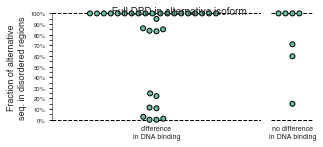

In [77]:
# check low values
gs_kw = dict(width_ratios=[2.5, 0.5])
fig, axarr = plt.subplots(1, 2, tight_layout=True, gridspec_kw=gs_kw, sharey=True)
fig.set_size_inches(h=2, w=4.5)

ax = axarr[0]
sns.swarmplot(data=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] != 0), :],
              y='f_disorder_difference',
              color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              ax=ax,
              clip_on=False
              )
ax.set_xlabel('difference\nin DNA binding')
ax.set_ylabel('Fraction of alternative\nseq. in disordered regions', fontsize=9)
ax.set_xticks([])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_ylim(-0.01, 1)
ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
ax.axhline(y=1, linestyle="dashed", linewidth=1, color="black", zorder=1)
ax.set_yticklabels(['{:.0%}'.format(y) for y in ax.get_yticks()])

ax = axarr[1]
sns.swarmplot(data=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] == 0), :],
              y='f_disorder_difference',
              color=sns.color_palette("Set2")[0],
               linewidth=1,
               edgecolor="black",
              ax=ax,
              clip_on=False
              )
ax.set_xlabel('no difference\nin DNA binding')
ax.set_xticks([])
for loc in ['top', 'bottom', 'right', 'left']:
    ax.spines[loc].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(which='both', length=0, zorder=1)
ax.set_ylabel('')
ax.axhline(y=0, linestyle="dashed", linewidth=1, color="black", zorder=1)
ax.axhline(y=1, linestyle="dashed", linewidth=1, color="black", zorder=1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('             Full DBD in alternative isoform\n', fontsize=10)
fig.savefig('../../figures/fig3/disordered-pct-alt-sequence_alt-isoforms-full-DBD-diff-PDI_dotplot.pdf',
            bbox_inches='tight')

In [78]:
x = list(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] != 0), 'f_disorder_difference'])
y = list(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] == 0), 'f_disorder_difference'])

In [79]:
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=112.0, pvalue=0.28017732313207544)

## exon diagrams

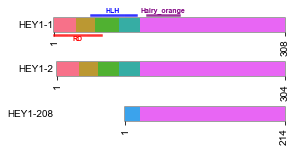

In [34]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs["HEY1"].protein_diagram(only_cloned_isoforms=False, draw_legend=False, ax=ax)
fig.savefig("../figures/HEY1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

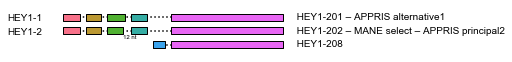

In [35]:
fig, ax = plt.subplots(figsize=(7, 0.75))

tfs["HEY1"].exon_diagram(ax=ax)
fig.savefig("../figures/HEY1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

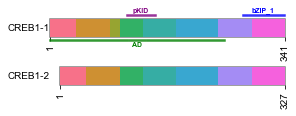

In [36]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs["CREB1"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../figures/CREB1_protein_diagram.pdf", bbox_inches="tight", dpi="figure")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  after removing the cwd from sys.path.
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


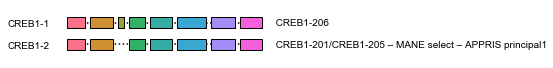

In [37]:
fig, ax = plt.subplots(figsize=(4, 1))

tfs["CREB1"].exon_diagram(ax=ax)
fig.savefig("../figures/CREB1_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  after removing the cwd from sys.path.


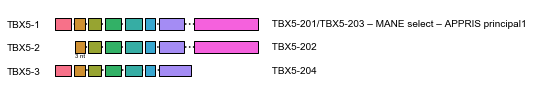

In [38]:
fig, ax = plt.subplots(figsize=(4, 1.5))

tfs["TBX5"].exon_diagram(ax=ax)
fig.savefig("../figures/TBX5_exon_diagram.pdf", bbox_inches="tight", dpi="figure")

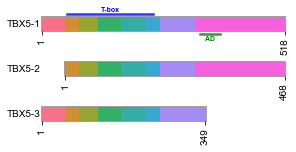

In [39]:
fig, ax = plt.subplots(figsize=(4, 2))

tfs["TBX5"].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../figures/TBX5_protein_diagram.pdf", bbox_inches="tight", dpi="figure")